Sveučilište u Zagrebu  
Fakultet elektrotehnike i računarstva  
  
## Strojno učenje 1 2023/2024  
http://www.fer.unizg.hr/predmet/struce1

------------------------------

### Druga laboratorijska vježba: Linearni diskriminativni modeli i logistička regresija

*Verzija: 1.1 (ispravljena greška u tekstu prvog zadatka)  
Zadnji put ažurirano: 1. 10. 2021.*

(c) 2015-2023 Jan Šnajder, Domagoj Alagić  

Rok za predaju: **5. studenog 2023. u 23:59h**

------------------------------

### Pravila predaje
Predajom vježbe potvrđujete sljedeće točke:
1. Niste od drugoga primili pomoć pri rješavanju vježbe;
2. Atribuirali ste dijelove koda koji su preuzeti s interneta referencirajući ih u komentarima;
3. Niste koristili dijelove koda s interneta koji su specifični za laboratorijsku vježbu;
4. Niste koristili UI-asistente za kodiranje kao npr. GitHub Copilot (uključivo alate generativne UI, kao što je ChatGPT).

**Povreda bilo kojeg od gornjih pravila smatra se prekršajem te povlači akademske sankcije.**

### Upute

Druga laboratorijska vježba sastoji se od šest zadataka. U nastavku slijedite upute navedene u ćelijama s tekstom. Rješavanje vježbe svodi se na **dopunjavanje ove bilježnice**: umetanja ćelije ili više njih **ispod** teksta zadatka, pisanja odgovarajućeg kôda te evaluiranja ćelija. 

Osigurajte da u potpunosti **razumijete** kôd koji ste napisali. Kod predaje vježbe, morate biti u stanju na zahtjev asistenta (ili demonstratora) preinačiti i ponovno evaluirati Vaš kôd. Nadalje, morate razumjeti teorijske osnove onoga što radite, u okvirima onoga što smo obradili na predavanju. Ispod nekih zadataka možete naći i pitanja koja služe kao smjernice za bolje razumijevanje gradiva (**nemojte pisati** odgovore na pitanja u bilježnicu). Stoga se nemojte ograničiti samo na to da riješite zadatak, nego slobodno eksperimentirajte. To upravo i jest svrha ovih vježbi.

Vježbe trebate raditi **samostalno**. Možete se konzultirati s drugima o načelnom načinu rješavanja, ali u konačnici morate sami odraditi vježbu. U protivnome vježba nema smisla.

In [2]:
# Učitaj osnovne biblioteke...
import sklearn
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [3]:
def plot_2d_clf_problem(X, y, h=None):
    '''
    Plots a two-dimensional labeled dataset (X,y) and, if function h(x) is given, 
    the decision surfaces.
    '''
    assert X.shape[1] == 2, "Dataset is not two-dimensional"
    if h != None:
        # Create a mesh to plot in
        r = 0.04  # mesh resolution
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, r),
                             np.arange(y_min, y_max, r))
        XX = np.c_[xx.ravel(), yy.ravel()]
        try:
            Z_test = h(XX)
            if Z_test.shape == ():
                # h returns a scalar when applied to a matrix; map explicitly
                Z = np.array(list(map(h, XX)))
            else:
                Z = Z_test
        except ValueError:
            # can't apply to a matrix; map explicitly
            Z = np.array(list(map(h, XX)))
        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        plt.contourf(xx, yy, Z, cmap=plt.cm.Pastel1)

    # Plot the dataset
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.tab20b, marker='o', s=50);

### 1. Linearna regresija kao klasifikator

U prethodnoj laboratorijskoj vježbi koristili smo model linearne regresije za, naravno, regresiju. Međutim, model linearne regresije može se koristiti i za **klasifikaciju**. Iako zvuči pomalo kontraintuitivno, zapravo je dosta jednostavno. Naime, cilj je naučiti funkciju $f(\mathbf{x})$ koja za pozitivne primjere predviđa vrijednost $1$, dok za negativne primjere predviđa vrijednost $0$. U tom slučaju, funkcija $f(\mathbf{x})=0.5$ predstavlja granicu između klasa, tj. primjeri za koje vrijedi $h(\mathbf{x})\geq 0.5$ klasificiraju se kao pozitivni, dok se ostali klasificiraju kao negativni.

Klasifikacija pomoću linearne regresije implementirana je u razredu [`RidgeClassifier`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeClassifier.html). U sljedećim podzadatcima **istrenirajte** taj model na danim podatcima i **prikažite** dobivenu granicu između klasa. Pritom isključite regularizaciju ($\alpha = 0$, odnosno `alpha=0`). Također i ispišite **točnost** vašeg klasifikacijskog modela (smijete koristiti funkciju [`metrics.accuracy_score`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html)). Skupove podataka vizualizirajte korištenjem pomoćne funkcije ``plot_clf_problem(X, y, h=None)`` koja je dana na početku ove bilježnice. `X` i `y` predstavljaju ulazne primjere i oznake, dok `h` predstavlja funkciju predikcije modela (npr. `model.predict`). 

U ovom zadatku cilj je razmotriti kako se klasifikacijski model linearne regresije ponaša na linearno odvojim i neodvojivim podatcima.

In [4]:
from sklearn.linear_model import LinearRegression, RidgeClassifier
from sklearn.metrics import accuracy_score

### (a)

Prvo, isprobajte *ugrađeni* model na linearno odvojivom skupu podataka `seven` ($N=7$).

In [5]:
seven_X = np.array([[2, 1], [2, 3], [1, 2], [3, 2], [5, 2], [5, 4], [6, 3]])
seven_y = np.array([1, 1, 1, 1, 0, 0, 0])

In [6]:
def classifyByRidgeClassifier(X, y):
    ridge_classifier = RidgeClassifier(alpha=0)
    ridge_classifier.fit(X, y)
    y_pred = ridge_classifier.predict(X)

    tocnost_klasifikacije = accuracy_score(y_true=y, y_pred=y_pred)
    print(f"Točnost klasifikacije iznosi: {tocnost_klasifikacije * 100}%")
    plot_2d_clf_problem(X, y, ridge_classifier.predict)

Točnost klasifikacije iznosi: 100.0%


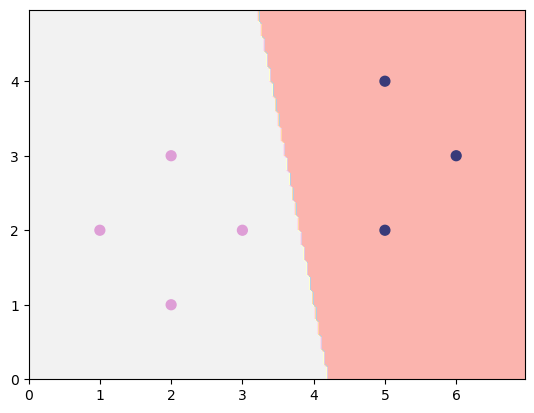

In [7]:
# Vaš kôd ovdje
classifyByRidgeClassifier(seven_X, seven_y)

Kako bi se uvjerili da se u isprobanoj implementaciji ne radi o ničemu doli o običnoj linearnoj regresiji, napišite kôd koji dolazi do jednakog rješenja korištenjem isključivo razreda [`LinearRegression`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html). Funkciju za predikciju, koju predajete kao treći argument `h` funkciji `plot_2d_clf_problem`, možete definirati lambda-izrazom: `lambda x : model.predict(x) >= 0.5`.

[ 1.   0.9  1.2  0.7  0.2  0.1 -0.1]


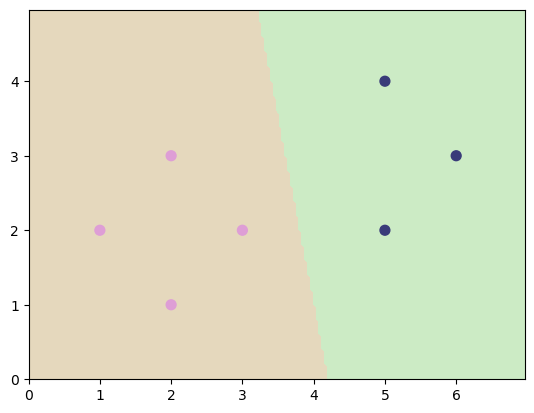

In [8]:
# Vaš kôd ovdje

linear_regresion = LinearRegression()
linear_regresion.fit(seven_X, seven_y)
print(linear_regresion.predict(seven_X))
h = lambda x: linear_regresion.predict(x) >= 0.5

plot_2d_clf_problem(seven_X, seven_y, h)

**Q:** Kako bi bila definirana granica između klasa ako bismo koristili oznake klasa $-1$ i $1$ umjesto $0$ i $1$?

### (b)  

Probajte isto na linearno odvojivom skupu podataka `outlier` ($N=8$):

In [11]:
outlier_X = np.append(seven_X, [[12, 8]], axis=0)
outlier_y = np.append(seven_y, 0)

o_X = np.array([[-2, 3], [-1, 2], [0,1], [0,0], [1,1], [1,-1], [2,0]])
o_y = np.array([-1,-1,-1,-1,-1,1,1])

Točnost klasifikacije iznosi: 100.0%


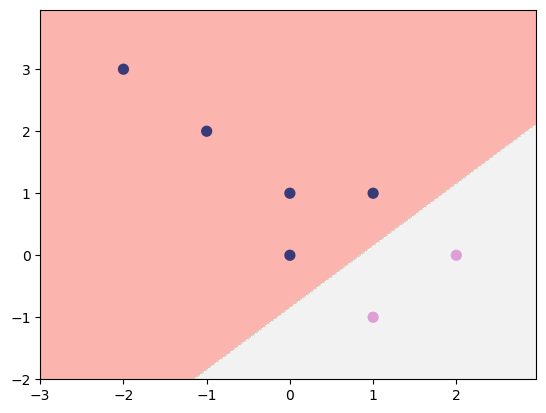

In [12]:
# Vaš kôd ovdje
classifyByRidgeClassifier(o_X, o_y)

**Q:** Zašto model ne ostvaruje potpunu točnost iako su podatci linearno odvojivi?

### (c)  

Završno, probajte isto na linearno neodvojivom skupu podataka `unsep` ($N=8$):

In [ ]:
unsep_X = np.append(seven_X, [[2, 2]], axis=0)
unsep_y = np.append(seven_y, 0)

In [ ]:
# Vaš kôd ovdje
classifyByRidgeClassifier(unsep_X, unsep_y)

**Q:** Očito je zašto model nije u mogućnosti postići potpunu točnost na ovom skupu podataka. Međutim, smatrate li da je problem u modelu ili u podacima? Argumentirajte svoj stav.

### 2. Višeklasna klasifikacija

Postoji više načina kako se binarni klasifikatori mogu se upotrijebiti za višeklasnu klasifikaciju. Najčešće se koristi shema tzv. **jedan-naspram-ostali** (engl. *one-vs-rest*, OVR), u kojoj se trenira po jedan klasifikator $h_j$ za svaku od $K$ klasa. Svaki klasifikator $h_j$ trenira se da razdvaja primjere klase $j$ od primjera svih drugih klasa, a primjer se klasificira u klasu $j$ za koju je $h_j(\mathbf{x})$ maksimalan.

Pomoću funkcije [`datasets.make_classification`](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html) generirajte slučajan dvodimenzijski skup podataka od tri klase i prikažite ga koristeći funkciju `plot_2d_clf_problem`. Radi jednostavnosti, pretpostavite da nema redundantnih značajki te da je svaka od klasa "zbijena" upravo u jednu grupu.

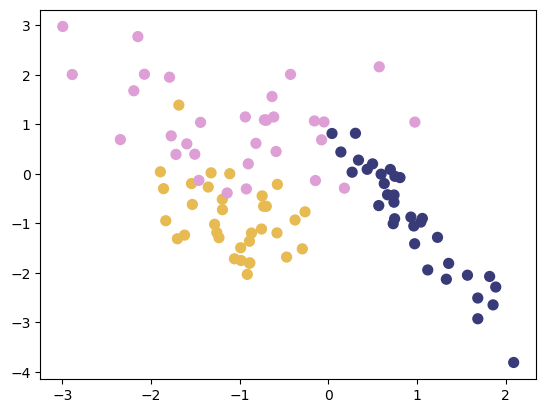

In [39]:
from sklearn.datasets import make_classification

X, y = make_classification(n_features=2, n_classes=3, n_informative=2, n_redundant=0, n_clusters_per_class=1)

plot_2d_clf_problem(X, y)

Trenirajte tri binarna klasifikatora, $h_1$, $h_2$ i $h_3$ te prikažite granice između klasa (tri grafikona). Zatim definirajte $h(\mathbf{x})=\mathrm{argmax}_j h_j(\mathbf{x})$  (napišite svoju funkciju `predict` koja to radi) i prikažite granice između klasa za taj model. Zatim se uvjerite da biste identičan rezultat dobili izravno primjenom modela `RidgeClassifier`, budući da taj model za višeklasan problem zapravo interno implementira shemu jedan-naspram-ostali.

**Q:** Alternativna shema jest ona zvana **jedan-naspram-jedan** (engl, *one-vs-one*, OVO). Koja je prednost sheme OVR nad shemom OVO? A obratno?

In [40]:
def OVR(X, y):
    linear_regresion = LinearRegression()
    linear_regresion.fit(X, y)

    h = lambda x: linear_regresion.predict(x) >= 0.5
    plot_2d_clf_problem(X, y, h)
    return linear_regresion


In [41]:
# Vaš kôd ovdje
all_h = []

y_1 = [1 if x == 0 else 0 for x in y]
y_2 = [1 if x == 1 else 0 for x in y]
y_3 = [1 if x == 2 else 0 for x in y]

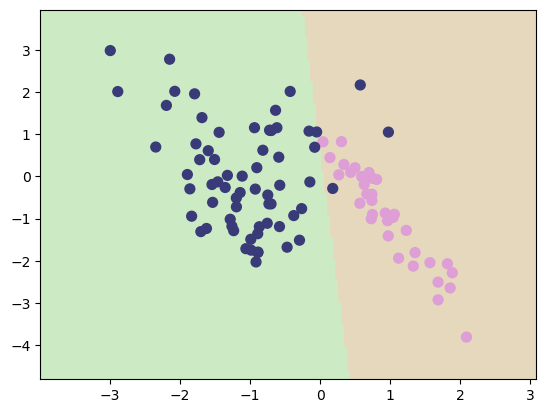

In [42]:
all_h.append(OVR(X, y_1))

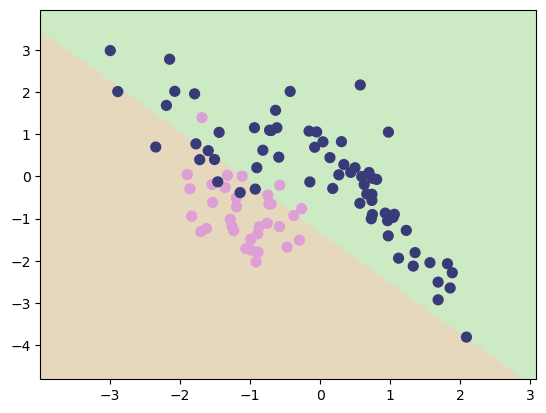

In [43]:
all_h.append(OVR(X, y_2))

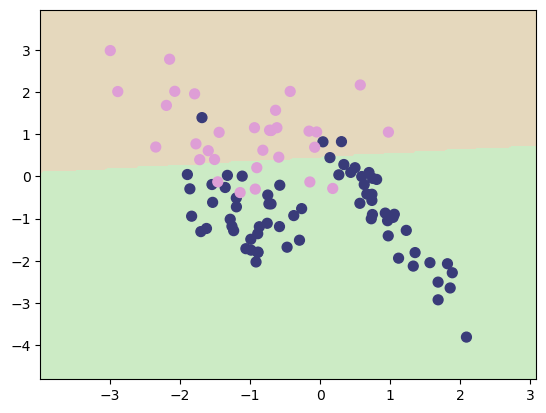

In [44]:
all_h.append(OVR(X, y_3))

In [45]:
def predict(X):
    y_pred = []
    h1_pred = all_h[0].predict(X)
    h2_pred = all_h[1].predict(X)
    h3_pred = all_h[2].predict(X)

    for i in range(len(h1_pred)):
        max_value = max(h1_pred[i], h2_pred[i], h3_pred[i])

        if max_value == h1_pred[i]:
            y_pred.append(0)
        elif max_value == h2_pred[i]:
            y_pred.append(1)
        else:
            y_pred.append(2)

    return np.array(y_pred)


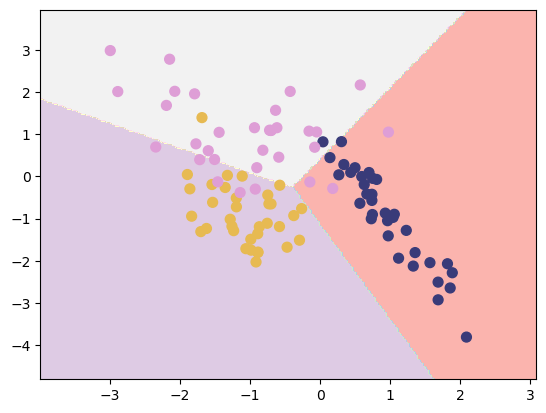

In [46]:
plot_2d_clf_problem(X, y, predict)

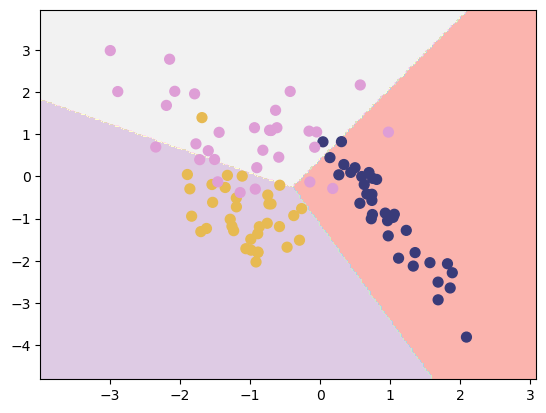

In [47]:
ridge_classifier = RidgeClassifier()
ridge_classifier.fit(X, y)
y_pred = ridge_classifier.predict(X)

plot_2d_clf_problem(X, y, ridge_classifier.predict)

### 3. Logistička regresija

Ovaj zadatak bavi se probabilističkim diskriminativnim modelom, **logističkom regresijom**, koja je, unatoč nazivu, klasifikacijski model.

Logistička regresija tipičan je predstavnik tzv. **poopćenih linearnih modela** koji su oblika: $h(\mathbf{x})=f(\mathbf{w}^\intercal\tilde{\mathbf{x}})$. Logistička funkcija za funkciju $f$ koristi tzv. **logističku** (sigmoidalnu) funkciju $\sigma (x) = \frac{1}{1 + \textit{exp}(-x)}$.

### (a)  

Definirajte logističku (sigmoidalnu) funkciju $\mathrm{sigm}(x)=\frac{1}{1+\exp(-\alpha x)}$ i prikažite je za $\alpha\in\{1,2,4\}$.

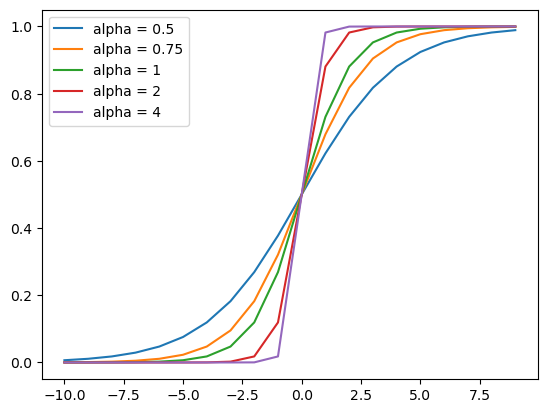

In [48]:
# Vaš kôd ovdje
import math

alpha_values = [0.5, 0.75, 1, 2, 4]
x_range_values = range(-10, 10)
for alpha in alpha_values:
    sigm = lambda x: 1 / (1 + math.exp(-alpha * x))
    y = []
    for x in x_range_values:
        y.append(sigm(x))
    plt.plot(x_range_values, y, label=f"alpha = {alpha}")

plt.legend(loc="best")
plt.show()

**Q**: Zašto je sigmoidalna funkcija prikladan izbor za aktivacijsku funkciju poopćenoga linearnog modela? 
</br>

**Q**: Kakav utjecaj ima faktor $\alpha$ na oblik sigmoide? Što to znači za model logističke regresije (tj. kako izlaz modela ovisi o normi vektora težina $\mathbf{w}$)?

### (b) 

Implementirajte funkciju 

> `lr_train(X, y, eta=0.01, max_iter=2000, alpha=0, epsilon=0.0001, trace=False)` 

za treniranje modela logističke regresije gradijentnim spustom (*batch* izvedba). Funkcija uzima označeni skup primjera za učenje (matrica primjera `X` i vektor oznaka `y`) te vraća $(n+1)$-dimenzijski vektor težina tipa `ndarray`. Ako je `trace=True`, funkcija dodatno vraća listu (ili matricu) vektora težina $\mathbf{w}^0,\mathbf{w}^1,\dots,\mathbf{w}^k$ generiranih kroz sve iteracije optimizacije, od 0 do $k$. Optimizaciju treba provoditi dok se ne dosegne `max_iter` iteracija, ili kada razlika u pogrešci unakrsne entropije između dviju iteracija padne ispod vrijednosti `epsilon`. Parametar `alpha` predstavlja faktor L2-regularizacije.

Preporučamo definiranje pomoćne funkcije `lr_h(x,w)` koja daje predikciju za primjer `x` uz zadane težine `w`. Također, preporučamo i funkciju `cross_entropy_error(X,y,w)` koja izračunava pogrešku unakrsne entropije modela na označenom skupu `(X,y)` uz te iste težine.

**NB:** Obratite pozornost na to da je način kako su definirane oznake ($\{+1,-1\}$ ili $\{1,0\}$) kompatibilan s izračunom funkcije gubitka u optimizacijskome algoritmu.

In [49]:
sigm = lambda x: 1 / (1 + np.exp(-x))


def lr_h(x, w):
    assert X is not None, 'Nedostaje matrica X'
    assert w is not None, 'Nedostaju tezine'

    if len(x) != len(w):
        x = PolynomialFeatures(degree=1).fit_transform(x.reshape(1, -1)).reshape(-1)

    y_prediction = np.dot(np.transpose(w), x).item()
    return sigm(y_prediction)


In [50]:
def cross_entropy_error(X, y, w):
    assert X is not None, 'Nedostaje matrica X'
    assert y is not None, 'Nedostaje y'
    assert w is not None, 'Nedostaju tezine'
    
    y_pred = [lr_h(x, w) for x in X]
    error = 0
    
    for i in range(len(y)):
        error += -y[i] * np.log(y_pred[i]) - (1 - y[i]) * np.log(1 - y_pred[i])

    return error / len(y)


In [79]:
def lr_train(X, y, eta=0.01, max_iter=2000, alpha=0, epsilon=0.0001, trace=False):
    y = [0 if y_ == -1 else y_ for y_ in y]
    X = PolynomialFeatures(degree=1).fit_transform(X)
    w = np.zeros((X.shape[1]))
    w_track = [np.array(w)]
    last_error = None
    error = 0
    num_of_itration = max_iter

    for iteration in range(max_iter):
        delta_w = np.zeros(w.shape)
        for i in range(len(X)):
            h = lr_h(X[i], w)
            delta_w = delta_w - (h - y[i]) * X[i]

        w[0] = w[0] + eta * delta_w[0]
        w[1:] = w[1:] * (1 - eta * alpha) + eta * delta_w[1:]
        
        w_track.append(np.array(w))

        if last_error is None:
            last_error = cross_entropy_error(X, y, w)
        else:
            error = cross_entropy_error(X, y, w)
            diff = math.fabs(error - last_error)
            last_error = error
            if diff < epsilon:
                num_of_itration = iteration + 1
                break

    if trace:
        return w_track, w, max_iter, error, num_of_itration
    else:
        return None, w, max_iter, error, num_of_itration


### (c)

Koristeći funkciju `lr_train`, trenirajte model logističke regresije na skupu `seven`, prikažite dobivenu granicu između klasa te  izračunajte pogrešku unakrsne entropije. 

**NB:** Pripazite da modelu date dovoljan broj iteracija.

In [52]:
seven_X = np.array([[2, 1], [2, 3], [1, 2], [3, 2], [5, 2], [5, 4], [6, 3]])
seven_y = np.array([1, 1, 1, 1, 0, 0, 0])

In [53]:
# Vaš kôd ovdje
w_track, w, max_iter, error, num_of_iteration = lr_train(seven_X, seven_y, trace=True)
print(f"w: {w}\nBroj iteracija: {num_of_iteration}\nError: {error}")

w: [ 4.45449454 -1.71089242  0.68413507]
Broj iteracija: 947
Error: 0.13521872720206746


**Q:** Koji kriterij zaustavljanja je aktiviran?

**Q:** Zašto dobivena pogreška unakrsne entropije nije jednaka nuli?

**Q:** Kako biste utvrdili da je optimizacijski postupak doista pronašao hipotezu koja minimizira pogrešku učenja? O čemu to ovisi?

**Q:** Na koji način biste preinačili kôd ako biste htjeli da se optimizacija izvodi stohastičkim gradijentnim spustom (*online learning*)?

### (d)

Prikažite na jednom grafikonu pogrešku unakrsne entropije (očekivanje logističkog gubitka) i pogrešku klasifikacije (očekivanje gubitka 0-1) na skupu `seven` kroz iteracije optimizacijskog postupka. Koristite trag težina funkcije `lr_train` iz zadatka (b) (opcija `trace=True`). Na drugom grafikonu prikažite pogrešku unakrsne entropije kao funkciju broja iteracija za različite stope učenja, $\eta\in\{0.005,0.01,0.05,0.1\}$.

In [55]:
from sklearn.metrics import zero_one_loss

In [56]:
def graph_cross_entropy_error(X,y,all_w):
    cross_entropy_errors = []
    for w_ in all_w:
        cross_entropy_errors.append(cross_entropy_error(X, y, w_))
        
    plt.plot(range(len(cross_entropy_errors)), cross_entropy_errors)
    plt.xlabel('Iteration') 
    plt.ylabel('Cross entropy error') 


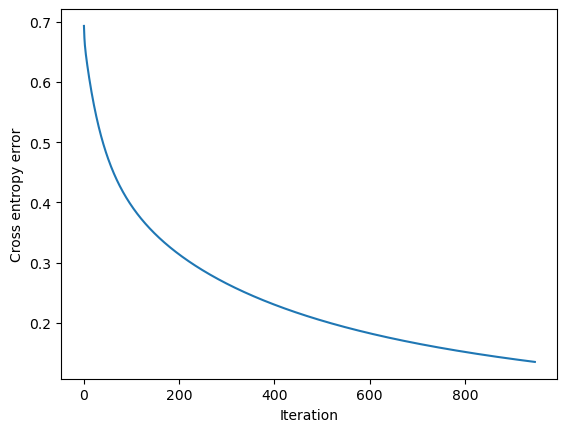

In [57]:
graph_cross_entropy_error(seven_X,seven_y,w_track)

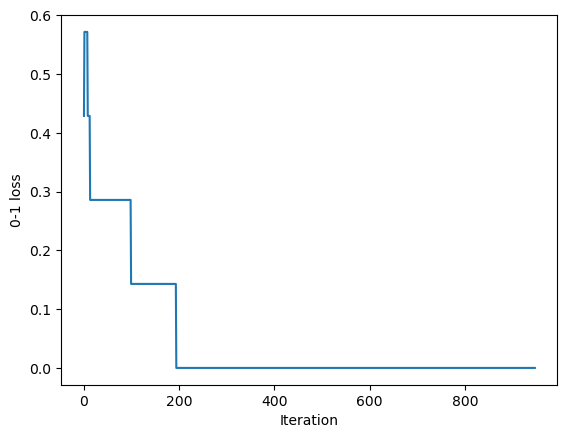

In [58]:
zero_one_erorrs = []
for w_ in w_track:
    y_pred = [lr_h(x,w_) >= 0.5 for x in seven_X]
    zero_one_erorrs.append(zero_one_loss(seven_y,y_pred))
    
plt.plot(range(num_of_iteration+1), zero_one_erorrs)
plt.xlabel('Iteration') 
plt.ylabel('0-1 loss') 
plt.show()

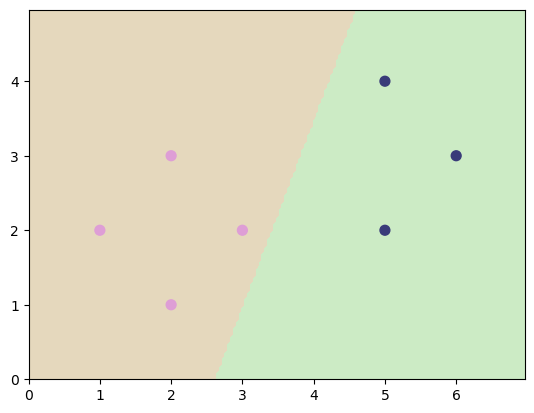

In [59]:
# Vaš kôd ovdje
plot_2d_clf_problem(seven_X, seven_y, lambda x : lr_h(x,w) >= 0.5)

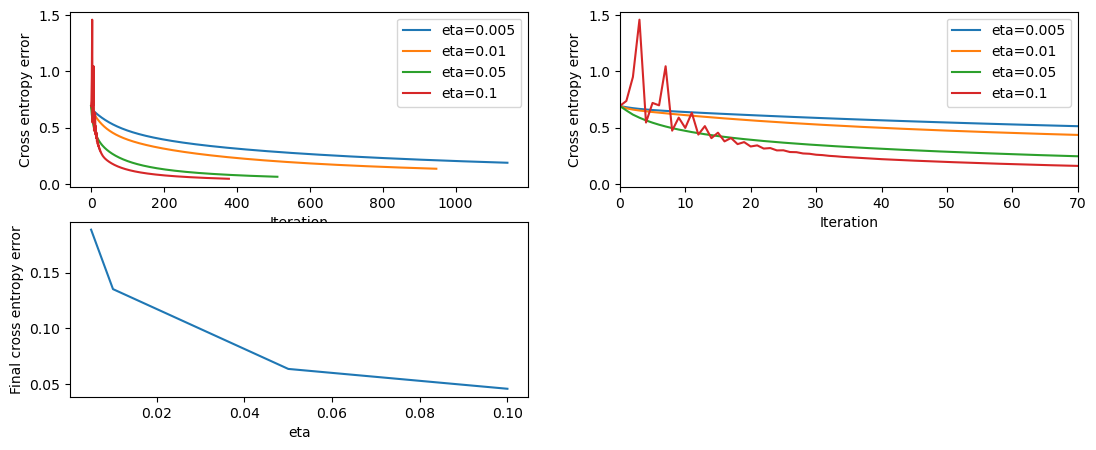

In [89]:
eta_values = [0.005, 0.01, 0.05, 0.1]
err_by_diff_eta = []
plt.figure(figsize=(13,5))
for eta in eta_values:
    w_track, w, max_iter, error, num_of_iteration = lr_train(seven_X, seven_y, eta=eta, trace=True)
    err_by_diff_eta.append(error)
    cross_entropy_errors = []
    for w_ in w_track:
        cross_entropy_errors.append(cross_entropy_error(seven_X, seven_y, w_))
        
    plt.subplot(2,2,1)
    plt.plot(range(len(cross_entropy_errors)), cross_entropy_errors, label=f"eta={eta}")
    plt.xlabel("Iteration")
    plt.ylabel("Cross entropy error")
    plt.legend()
    plt.subplot(2,2,2)
    plt.plot(range(len(cross_entropy_errors)), cross_entropy_errors, label=f"eta={eta}")
    plt.xlabel("Iteration")
    plt.ylabel("Cross entropy error")
    plt.xlim(0,70)
    plt.legend()
    
plt.subplot(2,2,3)
plt.plot(eta_values, err_by_diff_eta)
plt.xlabel("eta")
plt.ylabel("Final cross entropy error")
plt.show()


**Q:** Zašto je pogreška unakrsne entropije veća od pogreške klasifikacije? Je li to uvijek slučaj kod logističke regresije i zašto?

**Q:** Koju stopu učenja $\eta$ biste odabrali i zašto?

### (e)

Upoznajte se s klasom [`linear_model.LogisticRegression`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) koja implementira logističku regresiju. Usporedite rezultat modela na skupu `seven` s rezultatom koji dobivate pomoću vlastite implementacije algoritma.

**NB:** Kako ugrađena implementacija koristi naprednije verzije optimizacije funkcije, vrlo je vjerojatno da Vam se rješenja neće poklapati, ali generalne performanse modela bi trebale. Ponovno, pripazite na broj iteracija i snagu regularizacije.

In [98]:
from sklearn.linear_model import LogisticRegression

logisticRegresion = LogisticRegression(max_iter=2000, tol=0.0001, penalty=None).fit(seven_X,seven_y)
logisticRegresion.predict(seven_X)
print(f"Ispravna klasifikacija: {logisticRegresion.score(seven_X,seven_y) * 100}%")
print(logisticRegresion.intercept_,logisticRegresion.coef_)
print(logisticRegresion.n_iter_)

Ispravna klasifikacija: 100.0%
[46.26968486] [[-14.80304235   4.33454163]]
[21]


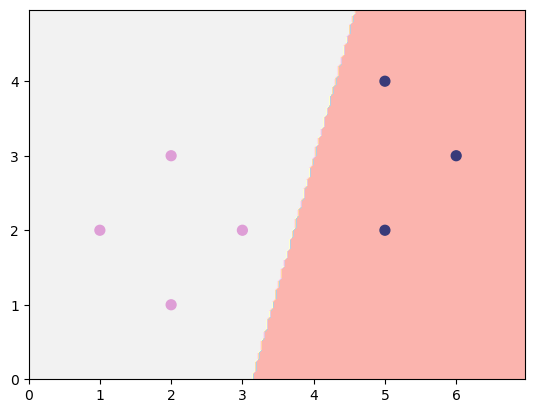

In [99]:
plot_2d_clf_problem(seven_X,seven_y, logisticRegresion.predict)

### 4. Analiza logističke regresije

### (a)

Koristeći ugrađenu implementaciju logističke regresije, provjerite kako se logistička regresija nosi s vrijednostima koje odskaču. Iskoristite skup `outlier`. Prikažite granicu između klasa.

In [63]:
outlier_X = np.append(seven_X, [[12, 8]], axis=0)
outlier_y = np.append(seven_y, 0)

Točnost klasifikacija: 100.0%


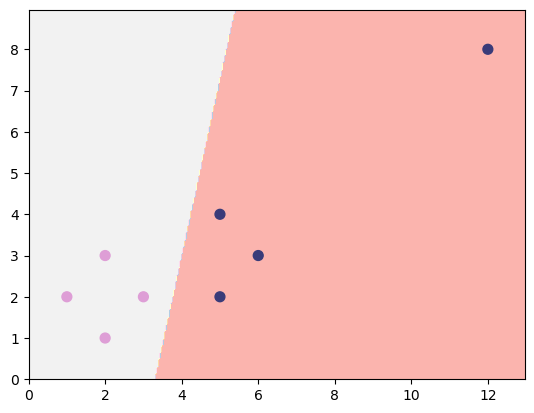

In [64]:
# Vaš kôd ovdje
logisticRegresion = LogisticRegression(penalty=None).fit(outlier_X,outlier_y)
plot_2d_clf_problem(outlier_X,outlier_y,logisticRegresion.predict)
print(f"Točnost klasifikacija: {logisticRegresion.score(seven_X,seven_y) * 100}%")

**Q:** Zašto se rezultat razlikuje od onog koji je dobio model klasifikacije linearnom regresijom iz prvog zadatka?

### (b)

Trenirajte model logističke regresije na skupu `seven` te na dva odvojena grafikona prikažite, kroz iteracije optimizacijskoga algoritma, (1) izlaz modela $h(\mathbf{x})$ za svih sedam primjera te (2) vrijednosti težina $w_0$, $w_1$, $w_2$.

In [65]:
# Vaš kôd ovdje
w_track, w, max_iter, error, num_of_iteration = lr_train(seven_X, seven_y, trace=True)

In [66]:
def graph_all_w(w_track):
    w_track = np.array(w_track)
    
    for i in range(w_track.shape[1]):
        plt.plot(range(num_of_iteration + 1), w_track[:,i], label=f"w{i}")
        
    plt.legend(loc="best")
    plt.xlabel('Iteration') 
    plt.ylabel('Tezina') 
    plt.show()

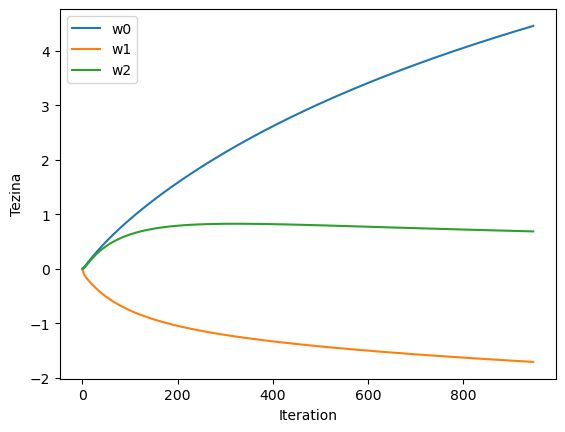

In [67]:
graph_all_w(w_track)

In [68]:
def print_h_label(x):
    x_size = len(x)
    label = "h(("
    for i in range(x_size):
        if i == x_size - 1:
            label += f"{x[i]}"
        else:
            label += f"{x[i]}, "
    return label + "))"


In [69]:
# Vaš kôd ovdje
def print_all_h(w_track,X):
    dict = {}
    for w_ in w_track:
        for i in range(len(X)):
            x = X[i]
            h = lr_h(x,w_)
            if i in dict:
                new_h_arr = np.append(dict.get(i), h)
                dict[i] = new_h_arr
            else:
                dict[i] = np.array([h])
    
    for key,value in dict.items():
        plt.plot(range(num_of_iteration+1), value, label=print_h_label(X[key]))
    
    plt.legend(loc="best")
    plt.xlabel('Iteration') 
    plt.ylabel('h(x)')
    plt.show()

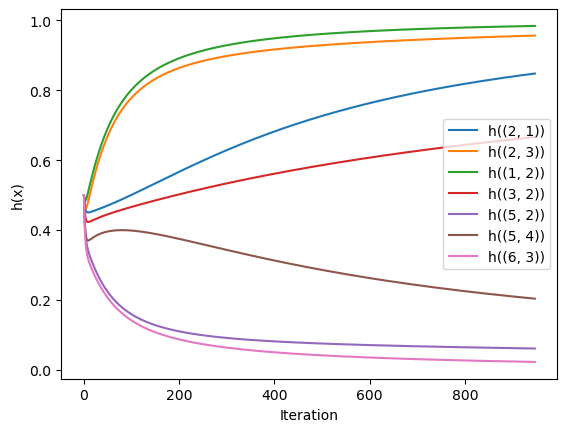

In [70]:
print_all_h(w_track, seven_X)

### (c)

Ponovite eksperiment iz podzadatka (b) koristeći linearno neodvojiv skup podataka `unsep`.

In [71]:
unsep_X = np.append(seven_X, [[2, 2]], axis=0)
unsep_y = np.append(seven_y, 0)

In [72]:
w_track, w, max_iter, error, num_of_iteration = lr_train(unsep_X, unsep_y, trace=True)

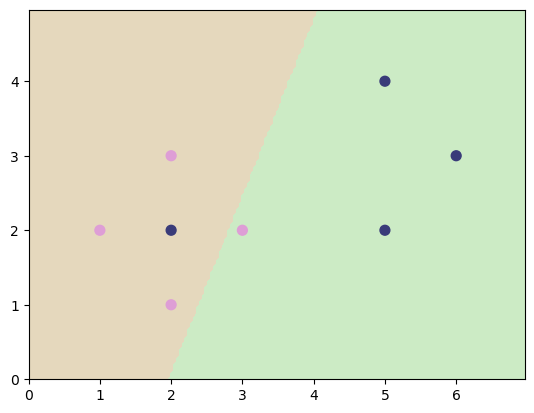

In [73]:
plot_2d_clf_problem(unsep_X,unsep_y, lambda x : lr_h(x,w) >= 0.5)

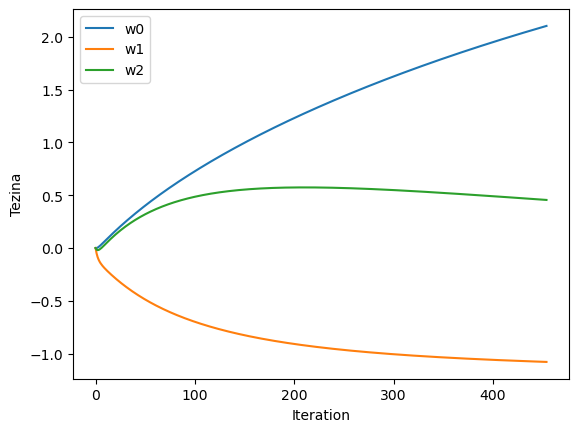

In [74]:
graph_all_w(w_track)

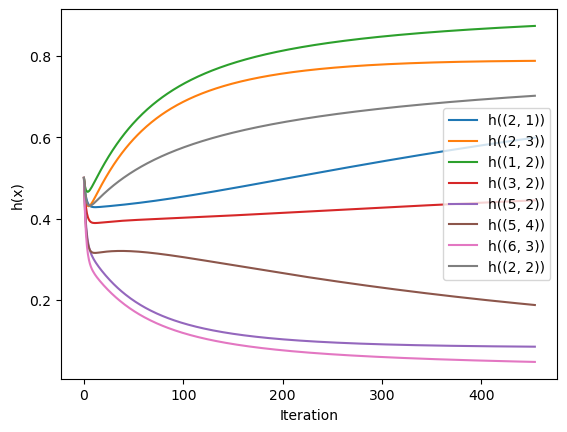

In [75]:
print_all_h(w_track,unsep_X)

**Q:** Usporedite grafikone za slučaj linearno odvojivih i linearno neodvojivih primjera te komentirajte razliku.

### 5. Regularizirana logistička regresija

Trenirajte model logističke regresije na skupu `seven` s različitim faktorima L2-regularizacije, $\alpha\in\{0,1,10,100\}$. Prikažite na dva odvojena grafikona (1) pogrešku unakrsne entropije te (2) L2-normu vektora $\mathbf{w}$ kroz iteracije optimizacijskog algoritma.

In [76]:
from numpy.linalg import norm

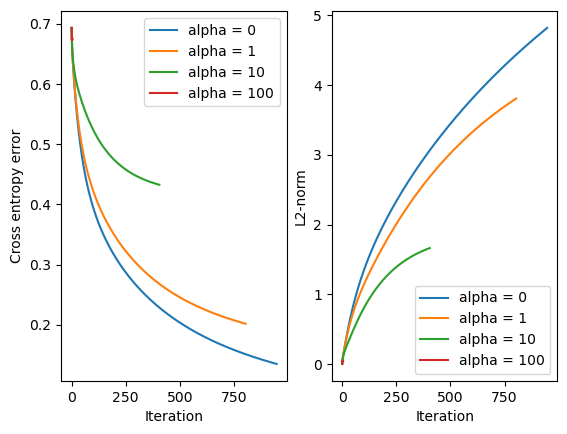

In [80]:
# Vaš kôd ovdje
seven_X = np.array([[2, 1], [2, 3], [1, 2], [3, 2], [5, 2], [5, 4], [6, 3]])
seven_y = np.array([1, 1, 1, 1, 0, 0, 0])
alpha_values = [0,1,10,100]
for alpha in alpha_values:
    w_track, w, max_iter, error, num_of_iteration = lr_train(seven_X, seven_y, trace=True, alpha=alpha)
    w_track = np.array(w_track)
    
    cross_entropy_errors = []
    norm_values = []
    for w_ in w_track:
        cross_entropy_errors.append(cross_entropy_error(seven_X, seven_y, w_))
        norm_values.append(norm(w_,ord=2))
    
    plt.subplot(1,2,1)
    plt.plot(range(len(cross_entropy_errors)), cross_entropy_errors, label = f"alpha = {alpha}")
    plt.xlabel('Iteration') 
    plt.ylabel('Cross entropy error')
    plt.legend()
    
    plt.subplot(1,2,2)
    plt.plot(range(len(norm_values)), norm_values, label = f"alpha = {alpha}")
    plt.xlabel('Iteration') 
    plt.ylabel('L2-norm')
    plt.legend()
    
plt.show()

**Q:** Jesu li izgledi krivulja očekivani i zašto?

**Q:** Koju biste vrijednost za $\alpha$ odabrali i zašto?

### 6. Logistička regresija s funkcijom preslikavanja

Proučite funkciju [`datasets.make_classification`](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html). Generirajte i prikažite dvoklasan skup podataka s ukupno $N=100$ dvodimenzijskih ($n=2)$ primjera, i to sa dvije grupe po klasi (`n_clusters_per_class=2`). Malo je izgledno da će tako generiran skup biti linearno odvojiv, međutim to nije problem jer primjere možemo preslikati u višedimenzijski prostor značajki pomoću klase [`preprocessing.PolynomialFeatures`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html), kao što smo to učinili kod linearne regresije u prvoj laboratorijskoj vježbi. Trenirajte model logističke regresije koristeći za preslikavanje u prostor značajki polinomijalnu funkciju stupnja $d=2$ i stupnja $d=3$. Prikažite dobivene granice između klasa. Možete koristiti svoju implementaciju, ali se radi brzine preporuča koristiti `linear_model.LogisticRegression`. Regularizacijski faktor odaberite po želji.

**NB:** Kao i ranije, za prikaz granice između klasa koristite funkciju `plot_2d_clf_problem`. Funkciji kao argumente predajte izvorni skup podataka, a preslikavanje u prostor značajki napravite unutar poziva funkcije `h` koja čini predikciju, na sljedeći način:

In [147]:
from sklearn.preprocessing import PolynomialFeatures

#plot_2d_clf_problem(X, y, lambda x : model.predict(poly.transform(x))

In [148]:
def learn_and_graph(X,y, degree):
    poly = PolynomialFeatures(degree=degree)
    logisticRegresion = LogisticRegression().fit(poly.fit_transform(X),y)
    plot_2d_clf_problem(X, y, lambda x : logisticRegresion.predict(poly.transform(x)))

In [194]:
from sklearn.datasets import make_classification
N = 100
n = 2
clusters_per_class = 2
X, y = make_classification(n_samples=N,n_features=n, n_informative=2, n_redundant=0, n_clusters_per_class=clusters_per_class)

# Vaš kôd ovdje

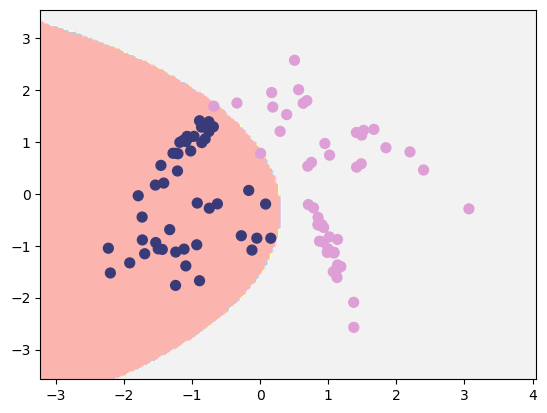

In [195]:
learn_and_graph(X,y,degree=2)

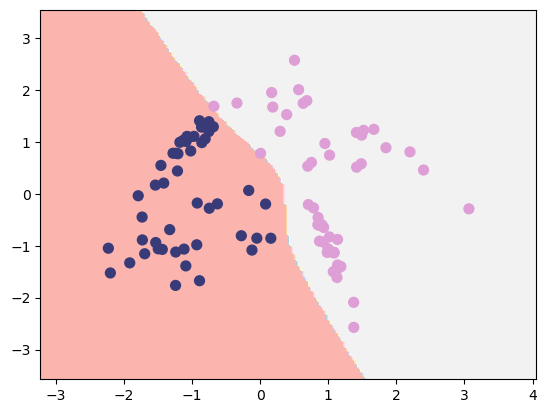

In [196]:
learn_and_graph(X,y,degree=3)

**Q:** Koji biste stupanj polinoma upotrijebili i zašto? Je li taj odabir povezan s odabirom regularizacijskog faktora $\alpha$? Zašto?